In [1]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
LW=5 # linewidth
MS=10 # markersize

In [2]:
def generate_truth(N, x0, H, del_step, Q, R):
    """Generate the truth for the second-order system"""
    del_t = 0.01
    g = 9.8 #m/s
    xout = np.zeros((N+1, 2))  
    m = H.shape[0]
    yout = np.empty((N, 1))
    yout[:] = np.nan
    xout[0, :] = x0
    for ii in range(N):
        xout[ii+1, 0] = xout[ii, 0] + (xout[ii, 1]*del_t)
        xout[ii+1, 1] = xout[ii, 1] - (g * np.sin(xout[ii,0]) * del_t)
        q_k = np.dot(np.linalg.cholesky(Q), np.random.randn(2))
        xout[ii+1, :] = xout[ii+1, :] + q_k
    
    for ii in range(0, N, del_step):
        r_delk = np.sqrt(R)*np.random.randn(1)
        yout[ii] = np.sin(xout[ii, 0]) + r_delk
        
    return xout, yout

In [3]:
x_init = [1.5, 0]
del_t = 0.01
del_step = 5
R = 1
q_c = 0.1
N_steps = 500
H = np.eye(2)
Q_cov = [[(q_c*(del_t**3))/3, (q_c*(del_t**2))/2], [(q_c*(del_t**2))/2, (q_c*del_t)]]
print(Q_cov)
xout, yout = generate_truth(N_steps, x_init, H, del_step, Q_cov, R)
print(xout.shape)
print(yout.shape)

[[3.333333333333334e-08, 5e-06], [5e-06, 0.001]]
(501, 2)
(500, 1)


In [4]:
DT = 1
T = 500
Nsims = int(T / DT)
t = np.linspace(0, T, Nsims+1)

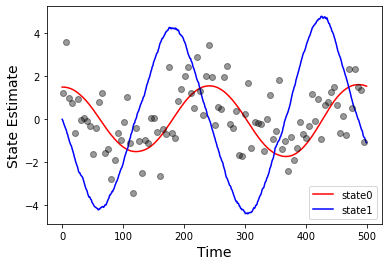

In [5]:
plt.figure()
plt.plot(t, xout[:, 0], color='red', label='state0')
plt.plot(t, xout[:, 1], color='blue', label='state1')
plt.plot(t[1:], yout[:, 0], 'ko', alpha=0.4)
#plt.plot(t[1:], yout[:, 1], 'kx', alpha=0.4)
plt.legend()
plt.xlabel('Time', fontsize=14)
plt.ylabel('State Estimate',fontsize=14)
plt.show()

In [6]:
def unscented_points(mean, cov, alg='svd', alpha=1, beta=0, kappa=0):
    """Generate unscented points"""    
    dim = cov.shape[0]
    lam = alpha*alpha*(dim + kappa) - dim
    if alg == "chol":
        L = np.linalg.cholesky(cov)
    elif alg == "svd":
        u, s, v = np.linalg.svd(cov)
        L = np.dot(u, np.sqrt(np.diag(s)))
    pts = np.zeros((2*dim+1, 2))
    pts[0, :] = mean.squeeze()
    for ii in range(1, dim+1):        
        pts[ii, :] = mean.squeeze() + np.sqrt(dim + lam)*L[:, ii-1]        
        pts[ii+dim,:] = mean.squeeze() - np.sqrt(dim + lam)*L[:, ii-1]

    W0m = lam / (dim + lam)
    W0C = lam / (dim + lam) + (1 - alpha*alpha + beta)
    Wim = 1/2 / (dim + lam)
    Wic = 1/2 / (dim + lam)
    return pts, (W0m, Wim, W0C, Wic)

In [7]:
# #check
# data =yout[0]
# H  =np.array([np.cos(0.5) , 0])
# H_T = H.T
# mean = np.array([1.5, 0])
# cov = np.eye(2)
# noise_cov= 1
# update_mean, update_cov= ekf_update_step(data, H, H_T, mean, cov, noise_cov)


In [8]:
def ukf_prediction_step( points_phi, wts_phi, mean, cov, noise_cov):
    
    pred_mean = np.zeros((2,1))
    func_for_mean = np.zeros((2,5))
    func_for_cov_p2to5 = np.zeros((2,2))
    del_t = 0.01
    g = 9.8
    num_points = 5
    
    func_for_mean[0, :] = points_phi[:, 0] + (points_phi[:, 1]*del_t)
    func_for_mean[1, :] = points_phi[:, 1] - (g*np.sin(points_phi[:, 0])*del_t)
   
    func_for_mean = func_for_mean.T
    pred_mean = (func_for_mean[0, :]*wts_phi[0] + wts_phi[1]*(func_for_mean[1, :] + func_for_mean[2, :] + func_for_mean[3, :] + func_for_mean[4, :])).reshape(-1,1)
#     pred_mean = np.reshape(pred_mean,(2,))
#     print(pred_mean)
    #print(func_for_mean[0,:])
    
    
    ####covariance for point 1
    func_for_cov_p1 = np.dot((func_for_mean[0, :].reshape(-1,1) - pred_mean), (func_for_mean[0, :].reshape(-1,1) - pred_mean).T)
    #print(func_for_cov_p1)
    for ii in range(1, num_points):
        ####covariance for points 2 to 5
        func_for_cov_p2to5 = func_for_cov_p2to5 + np.dot((func_for_mean[ii, :].reshape(-1,1) - pred_mean), (func_for_mean[ii, :].reshape(-1,1) - pred_mean).T)
        #print(func_for_cov_p2to5)

    pred_cov = (func_for_cov_p1*wts_phi[2]) + (wts_phi[3]*func_for_cov_p2to5) + noise_cov
    
    return pred_mean, pred_cov

In [9]:
# mean = np.array([1.5, 0])
# cov = np.eye(2)
# p, w = unscented_points(mean, cov, alg='chol', alpha=1, beta=0, kappa=0)
# print(p)
# print(w[0])


In [10]:
# del_t = 0.01
# g = 9.8
# mean_store = np.array([2, 3])
# A = np.array([[1, del_t], [-g*np.cos(mean_store[0])*del_t, 1]])
# A_T = A.T
# mean = np.array([1.5, 0])
# cov = np.eye(2)
# noise_cov = 1
# pred_mean, pred_cov = ukf_prediction_step(A, A_T, p, w, mean, cov, noise_cov)

In [11]:
def ukf_update_step(data, points_phi, wts_phi, mean, cov, noise_cov):
     
    num_points = 5
    h_p1 = np.sin(points_phi[0, 0])
    mu_p1 =  h_p1*wts_phi[0]
    mean = mean.squeeze()
    
    h_p2to5 = np.zeros((5,1))
    mu_p2to5 = 0
    U_p2to5 = 0
    S_p2to5 = 0
    for ii in range (1, num_points):
        h_p2to5[ii] = np.sin(points_phi[ii, 0])
    mu_p2to5 = np.sum(h_p2to5)*wts_phi[1]
    mu_tot = mu_p1 + mu_p2to5
    
    #U_p1 = np.matmul((points_phi[0, :] - mean), (h_p1 -  mu_p1))*wts_phi[2]
    U_p1 = np.dot((points_phi[0, :] - mean), (h_p1 -  mu_tot))*wts_phi[2]
    #S_p1 = np.matmul((h_p1 - mu_p1),(h_p1 - mu_p1).T)*wts_phi[2]
    S_p1 = np.dot((h_p1 - mu_tot),(h_p1 - mu_tot).T)*wts_phi[2]
    
    for ii in range(1, num_points):
        #U_p2to5 = U_p2to5 + np.matmul((points_phi[ii, :] - mean), (h_p2to5[ii] -  mu_tot))
        U_p2to5 += np.dot(((points_phi[ii, :] - mean)).reshape(2,1), (h_p2to5[ii] -  mu_tot).T)
        #S_p2to5 = S_p2to5 + np.matmul((h_p2to5[ii] -  mu_tot),(h_p2to5[ii] -  mu_tot).T)
        S_p2to5 += np.dot((h_p2to5[ii] -  mu_tot),(h_p2to5[ii] -  mu_tot).T)
        
    U_p2to5_weighted = U_p2to5*wts_phi[3]
    S_p2to5_weighted = S_p2to5*wts_phi[3]
    
    U_tot = U_p1 + U_p2to5_weighted
    S_tot = S_p1 + S_p2to5_weighted + noise_cov
    
    delta = data - [mu_tot, 0]

    #print(U.shape)
    update_mean = (mean + (U_tot*delta/S_tot)).reshape(2,1)
    update_mean = update_mean.reshape(2,)
    #print(update_mean.shape)
    #update_mean = mean + np.dot(cov, np.dot(H_T, np.linalg.solve(S, delta)))
    update_cov = cov - np.dot(U_tot, (U_tot.T)/(S_tot))
    #print(update_cov.shape)
    #update_cov = cov - np.dot(ch, np.linalg.solve(S, ch.T))
    return update_mean, update_cov

In [12]:
# #check
# data = yout[0]
# H  = np.array([np.cos(0.5) , 0])
# H_T = H.T
# mean = np.array([1.5, 0])
# cov = np.eye(2)
# noise_cov= 1
# update_mean, update_cov = ukf_update_step(data, H, H_T, p, w, mean, cov, noise_cov)
# print(update_mean)
# print(update_cov)

In [19]:
def unscented_kalman_filter(data, prior_mean, prior_cov, R):
  
    del_t = 0.01
    g = 9.8 #m/s
    qc = 0.1
    d = prior_mean.shape[0]
    N = data.shape[0]
    m = data.shape[1]
    
    mean_store = np.zeros((N+1, d))
    mean_store[0, :] = np.copy(prior_mean)
    cov_store = np.zeros((d, d, N+1))
    cov_store[:, :, 0] = np.copy(prior_cov)
    Q = [[(qc*(del_t**3))/3, (qc*(del_t**2))/2], [(qc*(del_t**2))/2, (qc*del_t)]]
    #R = 1
    
    #Loop over all data
    for ii in range(N):
        # Prediction
#         A_k = np.array([[1, del_t], [-g*np.cos(mean_store[ii, 0])*del_t, 1]])
#         A_k_trans = A_k.T
        H_k =np.array([[np.cos(mean_store[ii, 0]) ,0]])
        H_k_trans = H_k.T
        p_1, w_1 = unscented_points(mean_store[ii, :], cov_store[:, :, ii])
        #print('shape of p_1',p_1.shape)
        pred_mean, pred_cov = ukf_prediction_step( p_1, w_1, mean_store[ii, :], cov_store[:, :, ii], Q)
#         Update
        #print(mean_store.shape)
        if not np.isnan(data[ii]):
            p_2, w_2 = unscented_points(pred_mean, pred_cov)
            mean_store[ii+1, :], cov_store[:, :, ii+1] = ukf_update_step(data[ii, :], p_2,w_2, pred_mean, pred_cov, R)
        else:
            mean_store[ii+1, :] = pred_mean.squeeze()
            cov_store[:, :, ii+1] = pred_cov

    return mean_store, cov_store

In [20]:
def get_std(cov):
    """Get square root of diagonals (standard deviations) from covariances """
    
    d, d, N = cov.shape
    std_devs = np.zeros((N, d))
    for ii in range(N):
        std_devs[ii, :] = np.sqrt(np.diag(cov[:, :, ii]))
    return std_devs

In [21]:
data = yout
# R = 1
# prior_mean = np.array([1.5, 0])
# prior_cov = np.eye(2)

# mean_ekf, cov_ekf = unscented_kalman_filter(data, prior_mean, prior_cov, R)

In [22]:
K = 5 # time discretization error, only use a model that integrates at 5 times larger time step (and observes more rarely)
DTsim = 1
#Asim = DTsim * Asim + np.eye(2)
T = 500
Nsims_sim = int(T / DTsim)
tsim = np.linspace(0, T, Nsims_sim+1)
# yuse = yout[np.arange(K-1, yout.shape[0], K), :]

In [23]:
# std_devs = get_std(cov_ekf) #extract the standard deviations at all the states
# plt.figure(figsize=(7,7))
# plt.plot(t, xout[:, 0],'--', color='red', label='state0truth')
# plt.plot(t, xout[:, 1],'--', color='blue', label='state1truth')

# plt.plot(t, mean_ekf[:, 0], color='red', label='state0')
# plt.plot(t, mean_ekf[:, 1], color='blue', label='state1')
# plt.fill_between(t, mean_ekf[:, 0] - 2 * std_devs[:, 0],  mean_ekf[:, 0] + 2*std_devs[:, 0], color='red', alpha=0.3)
# plt.fill_between(t, mean_ekf[:, 1] - 2 * std_devs[:, 1],  mean_ekf[:, 1] + 2*std_devs[:, 1], color='blue', alpha=0.3)
# plt.plot(t[1:], yout[:], 'ko', alpha=0.4)
# # #plt.plot(t[1:], yout[:, 1], 'kx', alpha=0.4)
# #plt.plot(tsim[1:], yuse[:, 0], 'ko', alpha=0.4)
# #plt.plot(tsim[1:], yuse[:, 1], 'kx', alpha=0.4)
# plt.legend()
# plt.xlabel('Time', fontsize=14)
# plt.ylabel('State Estimate',fontsize=14)
# plt.show()

Time Elapsed for Unscented Kalman Filter with R = 1.0, delta = 5 0.03774690628051758
Mean squared error for state 1= 0.01726687612612927
Mean squared error for state 2= 0.0
Time Elapsed for Unscented Kalman Filter with R = 1.0, delta = 10 0.046869754791259766
Mean squared error for state 1= 0.05028889690302784
Mean squared error for state 2= 0.0
Time Elapsed for Unscented Kalman Filter with R = 1.0, delta = 20 0.03782033920288086
Mean squared error for state 1= 0.002114379790468379
Mean squared error for state 2= 0.0
Time Elapsed for Unscented Kalman Filter with R = 1.0, delta = 40 0.0312497615814209
Mean squared error for state 1= 0.045486369473233375
Mean squared error for state 2= 0.0


C:\Users\ivaishi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\ivaishi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\ivaishi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\ivaishi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


Time Elapsed for Unscented Kalman Filter with R = 0.1, delta = 5 0.053434133529663086
Mean squared error for state 1= 1.784470829770008e-05
Mean squared error for state 2= 0.0
Time Elapsed for Unscented Kalman Filter with R = 0.1, delta = 10 0.04292130470275879
Mean squared error for state 1= 4.286331470656497e-05
Mean squared error for state 2= 0.0
Time Elapsed for Unscented Kalman Filter with R = 0.1, delta = 20 0.0469057559967041
Mean squared error for state 1= 0.000645897651011254
Mean squared error for state 2= 0.0
Time Elapsed for Unscented Kalman Filter with R = 0.1, delta = 40 0.053400516510009766
Mean squared error for state 1= 0.0013251467989248177
Mean squared error for state 2= 0.0


C:\Users\ivaishi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\ivaishi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\ivaishi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\ivaishi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


Time Elapsed for Unscented Kalman Filter with R = 0.01, delta = 5 0.04698038101196289
Mean squared error for state 1= 0.017242953788859264
Mean squared error for state 2= 0.0
Time Elapsed for Unscented Kalman Filter with R = 0.01, delta = 10 0.036418914794921875
Mean squared error for state 1= 0.018561706581219247
Mean squared error for state 2= 0.0
Time Elapsed for Unscented Kalman Filter with R = 0.01, delta = 20 0.031244516372680664
Mean squared error for state 1= 0.02357999560839938
Mean squared error for state 2= 0.0
Time Elapsed for Unscented Kalman Filter with R = 0.01, delta = 40 0.03782391548156738
Mean squared error for state 1= 0.045863951224181514
Mean squared error for state 2= 0.0


C:\Users\ivaishi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\ivaishi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\ivaishi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\ivaishi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


Time Elapsed for Unscented Kalman Filter with R = 0.001, delta = 5 0.0540776252746582
Mean squared error for state 1= 0.0038370655276743003
Mean squared error for state 2= 0.0
Time Elapsed for Unscented Kalman Filter with R = 0.001, delta = 10 0.04090714454650879
Mean squared error for state 1= 0.021370764415764423
Mean squared error for state 2= 0.0
Time Elapsed for Unscented Kalman Filter with R = 0.001, delta = 20 0.04690074920654297
Mean squared error for state 1= 0.014309895465236767
Mean squared error for state 2= 0.0
Time Elapsed for Unscented Kalman Filter with R = 0.001, delta = 40 0.045380353927612305
Mean squared error for state 1= 0.09619131779670849
Mean squared error for state 2= 0.0


C:\Users\ivaishi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\ivaishi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\ivaishi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\ivaishi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


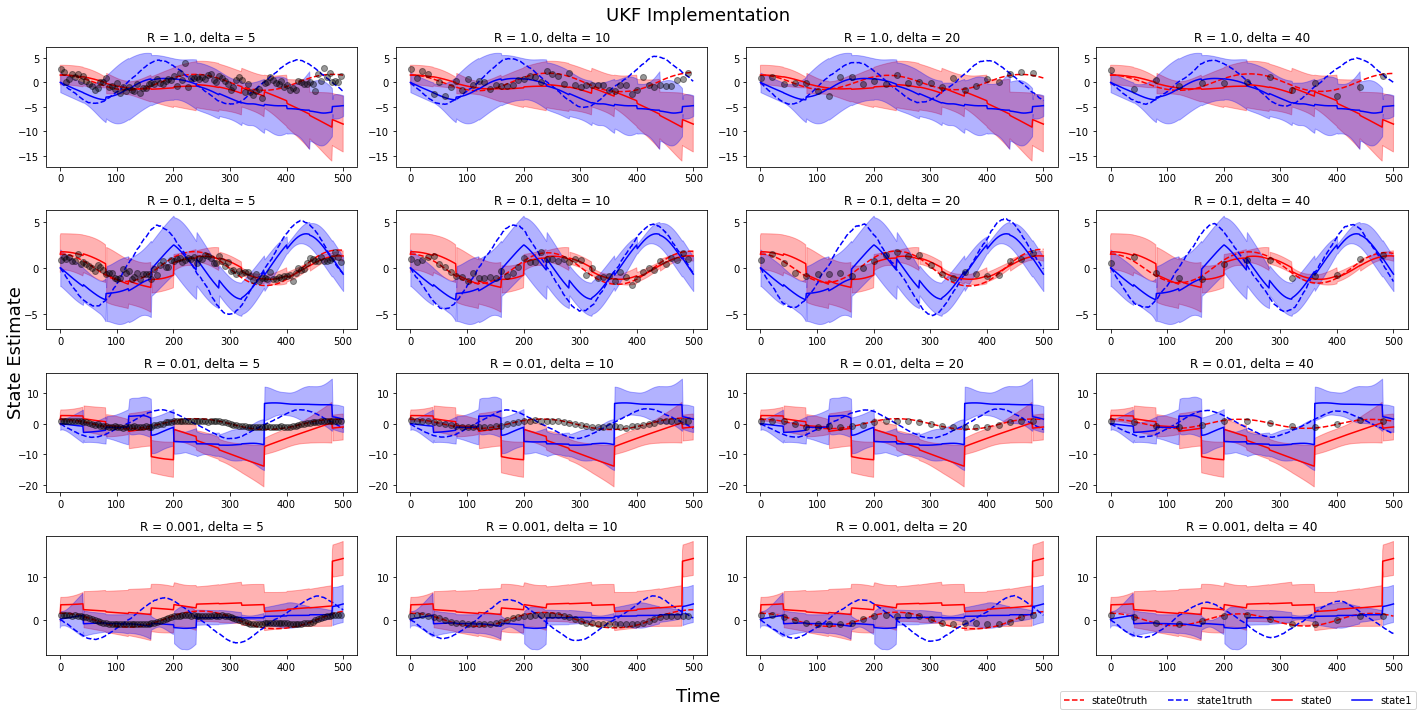

In [24]:
N = 500
x_init = np.array([1.5, 0])
g = 9.8 #m/s
prior_cov = np.eye(2)
R_set = np.array([1, 0.1, 0.01, 0.001])
delta_set = np.array([5, 10, 20, 40])
fig, subplt = plt.subplots(4, 4, figsize = (20,10))
data = yout

for ii in range(4):
    R = R_set[ii]
    for jj in range(4):
        del_step = delta_set[jj]
        tsim = np.linspace(0, T, N+1)
        
        xout, yout = generate_truth(N_steps, x_init, H, del_step, Q_cov, R) 
        start_time = time.time()
        mean_UKF, cov_UKF = unscented_kalman_filter(data, x_init, prior_cov, R)
        print("Time Elapsed for Unscented Kalman Filter with R = " + str(R) + ", delta = " + str(del_step), time.time() - start_time)
        
        for kk in range(0, xout.shape[0]):
            sq_err_s0 = np.zeros((xout.shape[0],1))
            sq_err_s1 = np.zeros((xout.shape[0],1))
            sq_err_s0[kk,:] = (xout[kk,0] - mean_UKF[kk,0])**2
            sq_err_s0[kk,:] = (xout[kk,1] - mean_UKF[kk,1])**2
        mean_sq_err_s0 = np.mean(sq_err_s0)
        print('Mean squared error for state 1=', mean_sq_err_s0)
        
        mean_sq_err_s1 = np.mean(sq_err_s1)
        print('Mean squared error for state 2=', mean_sq_err_s1)
        
        
        std_devs = get_std(cov_UKF)
        ax = subplt[ii,jj]
        ax.plot(t, xout[:, 0],'--', color='red', label='state0truth')
        ax.plot(t, xout[:, 1],'--', color='blue', label='state1truth')
        ax.plot(tsim, mean_UKF[:, 0], color='red', label='state0')
        ax.plot(tsim, mean_UKF[:, 1], color='blue', label='state1')
        ax.plot(t[1:], yout[:], 'ko', alpha=0.4)
        ax.fill_between(t, mean_UKF[:, 0] - 2 * std_devs[:, 0],  mean_UKF[:, 0] + 2*std_devs[:, 0], color='red', alpha=0.3)
        ax.fill_between(t, mean_UKF[:, 1] - 2 * std_devs[:, 1],  mean_UKF[:, 1] + 2*std_devs[:, 1], color='blue', alpha=0.3)
        ax.set_title("R = " + str(R) + ", delta = " + str(del_step))
fig.suptitle('UKF Implementation', fontsize = 18)
fig.supxlabel('Time', fontsize = 18)
fig.supylabel('State Estimate', fontsize = 18)
fig.legend(["state0truth", "state1truth", "state0", "state1"], loc = 'lower right', ncol = 5, bbox_transform = fig.transFigure)
fig.tight_layout()
plt.show()